In [262]:
import pandas as pd
import numpy as np
import datetime
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt
import folium

In [263]:
siniestros = pd.read_csv('siniestrosEDA.csv')

***
***

# KPI 1

### KPI 1: Reducir en un 10% la tasa de homicidios en siniestros viales de los últimos seis meses, en CABA, en comparación con la tasa de homicidios en siniestros viales del semestre anterior

Haré un df que sea: año / semestre / homicidios semestre actual / homicidios semestre anterior / porcentual diferencia

In [264]:
kpi_1 = siniestros.copy()

In [265]:
kpi_1 = kpi_1[kpi_1['FATAL']==1]

Creo columna para semestre que tomará valores 1 y 2

In [266]:
kpi_1['SEMESTRE'] = (kpi_1['M'] - 1) // 6 + 1

Agrupo por año y semestre, y cuento cantidad de registros (que es cantidad de víctimas)

In [267]:
kpi_1 = kpi_1.groupby(['A', 'SEMESTRE']).size().reset_index(name='HOMICIDIOS')

Creo la nueva columna SEMESTRE_ANTERIOR que obtiene el dato de HOMICIDIOS del semestre anterior

In [268]:
kpi_1['SEMESTRE_ANTERIOR'] = kpi_1['HOMICIDIOS'].shift(periods=1, fill_value=0)

La población en CABA según censo de 2022 es de 3120612 habitantes. Tomamos la tasa de homicidios como la cantidad de homicidios cada 100000 habitantes

In [269]:
kpi_1['TASA_HOMICIDIOS'] = (kpi_1['HOMICIDIOS']/3120612) * 100000
kpi_1['TASA_SEMESTRE_ANTERIOR'] = (kpi_1['SEMESTRE_ANTERIOR']/3120612) * 100000

Tomamos la Variación Porcentual (%) = ((Nuevo Valor - Valor Antiguo) / Valor Antiguo) * 100

In [270]:
kpi_1['VARIACION'] = (kpi_1['HOMICIDIOS'] - kpi_1['SEMESTRE_ANTERIOR']) / kpi_1['SEMESTRE_ANTERIOR'] * 100
kpi_1['VARIACION'] = (kpi_1['TASA_HOMICIDIOS'] - kpi_1['TASA_SEMESTRE_ANTERIOR']) / kpi_1['TASA_SEMESTRE_ANTERIOR'] * 100

In [271]:
kpi_1

,A,SEMESTRE,HOMICIDIOS,SEMESTRE_ANTERIOR,TASA_HOMICIDIOS,TASA_SEMESTRE_ANTERIOR,VARIACION
0,2016,1,64,0,2.050880,0.000000,inf
1,2016,2,78,64,2.499510,2.050880,21.875000
2,2017,1,65,78,2.082925,2.499510,-16.666667
3,2017,2,70,65,2.243150,2.082925,7.692308
4,2018,1,69,70,2.211105,2.243150,-1.428571
5,2018,2,79,69,2.531555,2.211105,14.492754
6,2019,1,57,79,1.826565,2.531555,-27.848101
7,2019,2,46,57,1.474070,1.826565,-19.298246
8,2020,1,30,46,0.961350,1.474070,-34.782609
9,2020,2,49,30,1.570205,0.961350,63.333333


* Si bien podemos notar que hay una tendencia a la baja, también vemos que hay semestres con subas respecto al semestre anterior.
* Se observa que el semestre 1 del 2020 es el que posee la mayor baja y se explica por la menor circulación de autos debido a las restricciones por la pandemia de Coronavirus.
* En el último semestre analizado se cumple con creces el kpi buscado, ya que se baja en un 23% la tasa de homicidios respecto al semestre anterior
* No es una curva estacionaria, sino una curva con tendencia a la baja

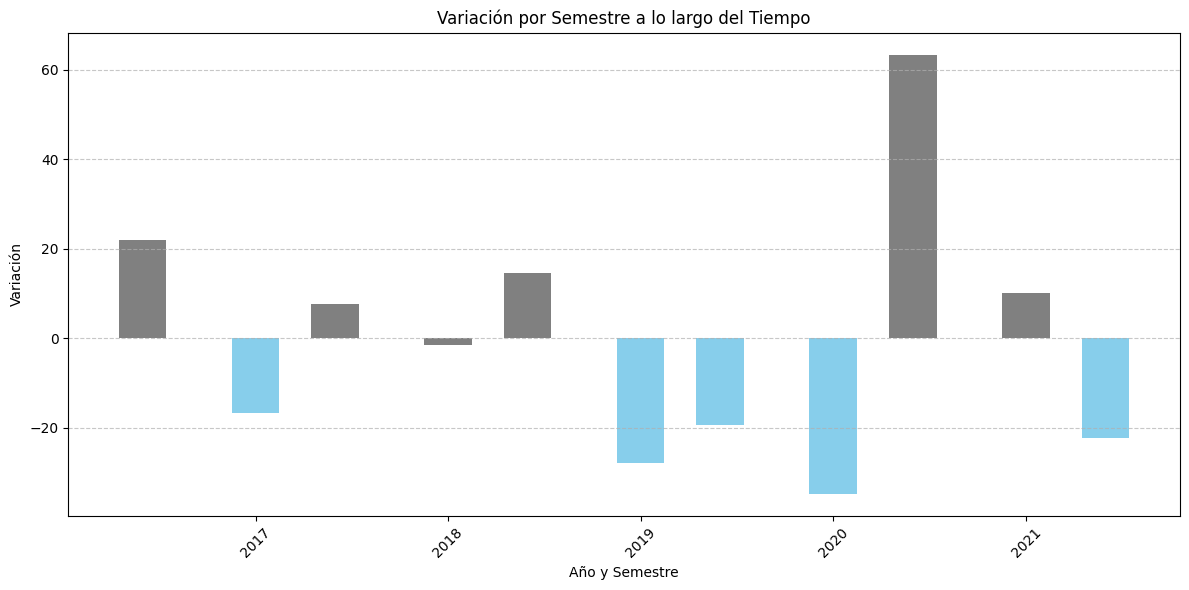

In [272]:
kpi_1['SEMESTRE'] = [6 if a == 2 else a for a in kpi_1['SEMESTRE']]
kpi_1['A'] = pd.to_numeric(kpi_1['A'], errors='coerce')
kpi_1['SEMESTRE'] = pd.to_numeric(kpi_1['SEMESTRE'], errors='coerce')
kpi_1 = kpi_1.dropna(subset=['A', 'SEMESTRE'])
kpi_1['A'] = kpi_1['A'].astype(int)
kpi_1['SEMESTRE'] = kpi_1['SEMESTRE'].astype(int)
kpi_1['FECHA'] = kpi_1['A'].astype(str) + '-' + kpi_1['SEMESTRE'].astype(str) + '-01'
kpi_1['FECHA'] = pd.to_datetime(kpi_1['FECHA'], format='%Y-%m-%d')

plt.figure(figsize=(12, 6))
colores = ['skyblue' if valor < -10 else 'gray' for valor in kpi_1['VARIACION']]
plt.bar(kpi_1['FECHA'], kpi_1['VARIACION'], color=colores, width=90)
plt.xlabel('Año y Semestre')
plt.ylabel('Variación')
plt.title('Variación por Semestre a lo largo del Tiempo')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Exportamos para utilizarlo luego con Streamlit

In [273]:
kpi_1.to_csv('kpi_1.csv', index=False)

***
***

# KPI 2

### KPI 2: Reducir en un 7% la cantidad de accidentes mortales de motociclistas en el último año, en CABA, respecto al año anterior

Haré un df que sea: año / homicidios año actual / homicidios año anterior / porcentual diferencia

In [274]:
kpi_2 = siniestros.copy()

In [275]:
kpi_2 = kpi_2[kpi_2['FATAL']==1]

Me quedo únicamente con los registros cuya víctima es motociclista

In [276]:
kpi_2 = kpi_2[kpi_2['VICTIMA'] == 'MOTO']

Agrupo por año y cuento cantidad de registros (que es cantidad de víctimas)

In [277]:
kpi_2 = kpi_2.groupby(['A']).size().reset_index(name='HOMICIDIOS')

Creo la nueva columna AÑO_ANTERIOR que obtiene el dato de HOMICIDIOS del año anterior

In [278]:
kpi_2['AÑO_ANTERIOR'] = kpi_2['HOMICIDIOS'].shift(periods=1, fill_value=0)

La población en CABA según censo de 2022 es de 3120612 habitantes. Tomamos la tasa de homicidios como la cantidad de homicidios cada 100000 habitantes

In [279]:
kpi_2['TASA_HOMICIDIOS'] = (kpi_2['HOMICIDIOS']/3120612) * 100000
kpi_2['TASA_AÑO_ANTERIOR'] = (kpi_2['AÑO_ANTERIOR']/3120612) * 100000

Tomamos la Variación Porcentual (%) = ((Nuevo Valor - Valor Antiguo) / Valor Antiguo) * 100

In [280]:
kpi_2['VARIACION'] = (kpi_2['HOMICIDIOS'] - kpi_2['AÑO_ANTERIOR']) / kpi_2['AÑO_ANTERIOR'] * 100
kpi_2['VARIACION'] = (kpi_2['TASA_HOMICIDIOS'] - kpi_2['TASA_AÑO_ANTERIOR']) / kpi_2['TASA_AÑO_ANTERIOR'] * 100

In [281]:
kpi_2

,A,HOMICIDIOS,AÑO_ANTERIOR,TASA_HOMICIDIOS,TASA_AÑO_ANTERIOR,VARIACION
0,2016,63,0,2.018835,0.000000,inf
1,2017,52,63,1.666340,2.018835,-17.460317
2,2018,57,52,1.826565,1.666340,9.615385
3,2019,49,57,1.570205,1.826565,-14.035088
4,2020,28,49,0.897260,1.570205,-42.857143
5,2021,45,28,1.442025,0.897260,60.714286


* Se observa que el año 2020 es el que posee la mayor baja y se explica por la menor circulación de autos debido a las restricciones por la pandemia de Coronavirus.
* Se observa una tendencia a la baja en accidentes fatales de motociclistas, expetuando el caso atípico de la baja del año 2020 y el consecuente pico del año 2021, que aun sigue siendo menor que el año 2019
* En el último año analizado no se cumple el kpi buscado, ya que sube un 58% la tasa de homicidios respecto al año anterior, pero si vemos otros años que no se vean afectados por el caso atípico del año 2020, vemos que se cumple el KPI (porn ejemplo en el año 2017 y 2019 la baja de la tasa de accidentes fatales de motociclistas respecto al año anterior fue sobradamente menor que el 7%)
* No es una curva estacionaria, sino una curva con tendencia a la baja

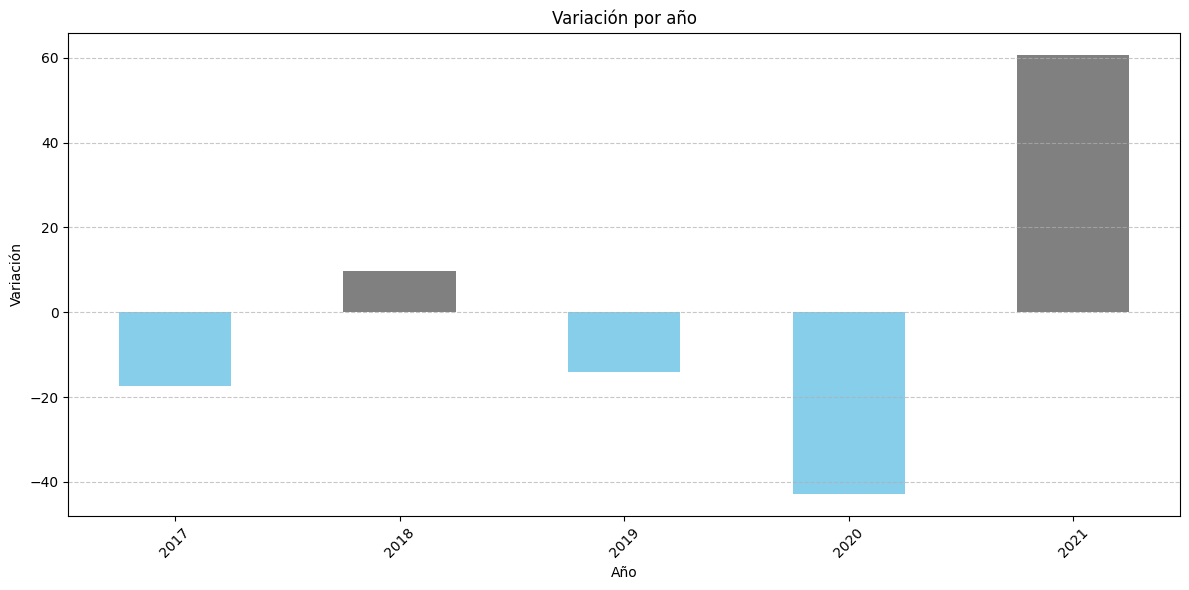

In [282]:
plt.figure(figsize=(12, 6))
colores = ['skyblue' if valor < -7 else 'gray' for valor in kpi_2['VARIACION']]
plt.bar(kpi_2['A'], kpi_2['VARIACION'], color=colores, width=0.5)
plt.xlabel('Año')
plt.ylabel('Variación')
plt.title('Variación por año')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Exportamos para utilizarlo luego con Streamlit

In [283]:
kpi_2.to_csv('kpi_2.csv', index=False)

***
***

# KPI 3

### KPI 3: Reducir en un 10% la cantidad de accidentes mortales de peatones en el último año respecto al año anterior

Haré un df que sea: año / homicidios año actual / homicidios año anterior / porcentual diferencia

In [284]:
kpi_3 = siniestros.copy()

In [285]:
kpi_3 = kpi_3[kpi_3['FATAL']==1]

Me quedo únicamente con los registros cuya víctima es peatón

In [286]:
kpi_3 = kpi_3[kpi_3['VICTIMA'] == 'PEATON']

Agrupo por año y cuento cantidad de registros (que es cantidad de víctimas)

In [287]:
kpi_3 = kpi_3.groupby(['A']).size().reset_index(name='HOMICIDIOS')

Creo la nueva columna AÑO_ANTERIOR que obtiene el dato de HOMICIDIOS del año anterior

In [288]:
kpi_3['AÑO_ANTERIOR'] = kpi_3['HOMICIDIOS'].shift(periods=1, fill_value=0)

La población en CABA según censo de 2022 es de 3120612 habitantes. Tomamos la tasa de homicidios como la cantidad de homicidios cada 100000 habitantes


In [289]:
kpi_3['TASA_HOMICIDIOS'] = (kpi_3['HOMICIDIOS']/3120612) * 100000
kpi_3['TASA_AÑO_ANTERIOR'] = (kpi_3['AÑO_ANTERIOR']/3120612) * 100000

Tomamos la Variación Porcentual (%) = ((Nuevo Valor - Valor Antiguo) / Valor Antiguo) * 100

In [290]:
kpi_3['VARIACION'] = (kpi_3['HOMICIDIOS'] - kpi_3['AÑO_ANTERIOR']) / kpi_3['AÑO_ANTERIOR'] * 100
kpi_3['VARIACION'] = (kpi_3['TASA_HOMICIDIOS'] - kpi_3['TASA_AÑO_ANTERIOR']) / kpi_3['TASA_AÑO_ANTERIOR'] * 100

In [291]:
kpi_3

,A,HOMICIDIOS,AÑO_ANTERIOR,TASA_HOMICIDIOS,TASA_AÑO_ANTERIOR,VARIACION
0,2016,48,0,1.538160,0.000000,inf
1,2017,49,48,1.570205,1.538160,2.083333
2,2018,65,49,2.082925,1.570205,32.653061
3,2019,35,65,1.121575,2.082925,-46.153846
4,2020,34,35,1.089530,1.121575,-2.857143
5,2021,33,34,1.057485,1.089530,-2.941176


* Se observan muchas fluctuaciones, con una tendencia a la baja.
* El KPI buscado no se cumplió el último año, pero igualmente hubo una baja del 5.7% de accidentes fatales de peatones en el último año.
* La mayor baja se produjo en 2019 comparado con 2018 (baja del 46.9%). De todas maneras, 2018 fue un año con una crecida fuerte respecto al año anterior (suba del 34.6%)

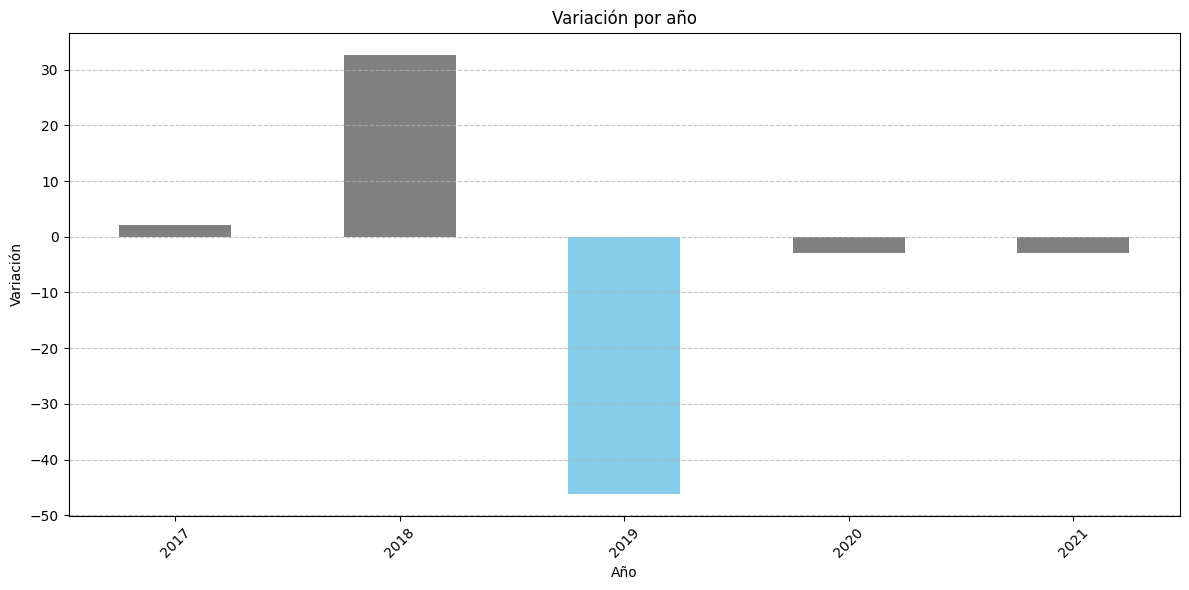

In [292]:
plt.figure(figsize=(12, 6))
colores = ['skyblue' if valor < -10 else 'gray' for valor in kpi_3['VARIACION']]
plt.bar(kpi_3['A'], kpi_3['VARIACION'], color=colores, width=0.5)
plt.xlabel('Año')
plt.ylabel('Variación')
plt.title('Variación por año')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Exportamos para utilizarlo luego con Streamlit

In [293]:
kpi_3.to_csv('kpi_3.csv', index=False)

***
***

# Otras visualizaciones interesantes

In [294]:
homicidios = siniestros[siniestros['FATAL']==1]

In [295]:
homicidios

,ID,FECHA,A,M,D,H,COMUNA,LONGITUD,LATITUD,TIPO_CALLE,ACUSADO,VICTIMA,FATAL,DIA_SEMANA
0,2016-0001,2016-01-01,2016,1,1,4,8,-58.475340,-34.687570,AVENIDA,AUTO,MOTO,1,Viernes
1,2016-0002,2016-01-02,2016,1,2,1,9,-58.508775,-34.669777,GRAL PAZ,PASAJEROS,AUTO,1,Sábado
2,2016-0003,2016-01-03,2016,1,3,7,1,-58.390403,-34.631894,AVENIDA,AUTO,MOTO,1,Domingo
3,2016-0004,2016-01-10,2016,1,10,0,8,-58.465039,-34.680930,AVENIDA,SD,MOTO,1,Domingo
4,2016-0005,2016-01-21,2016,1,21,5,1,-58.387183,-34.622466,AVENIDA,PASAJEROS,MOTO,1,Jueves
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
698,2021-0092,2021-12-12,2021,12,12,6,3,-58.405969,-34.610120,AVENIDA,AUTO,PEATON,1,Domingo
699,2021-0093,2021-12-13,2021,12,13,17,7,-58.433538,-34.645616,AVENIDA,AUTO,MOTO,1,Lunes
700,2021-0094,2021-12-20,2021,12,20,1,9,-58.467398,-34.651178,AUTOPISTA,AUTO,MOTO,1,Lunes
701,2021-0095,2021-12-30,2021,12,30,0,11,-58.472934,-34.619847,AVENIDA,CARGAS,MOTO,1,Jueves


# Cantidad de muertes según horario (gráfico de barras)

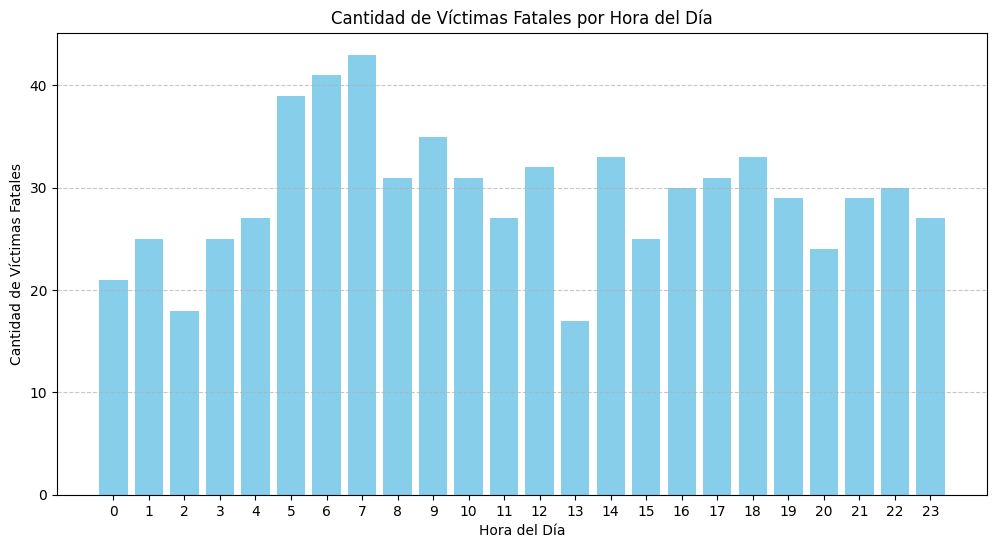

In [296]:
# Contar las víctimas fatales por hora
victimas_por_hora = homicidios['H'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(victimas_por_hora.index, victimas_por_hora.values, color='skyblue')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Víctimas Fatales')
plt.title('Cantidad de Víctimas Fatales por Hora del Día')
plt.xticks(range(24))  # Etiquetas del eje x para cada hora
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Cantidad de muertes según el mes (gráfico de barra)

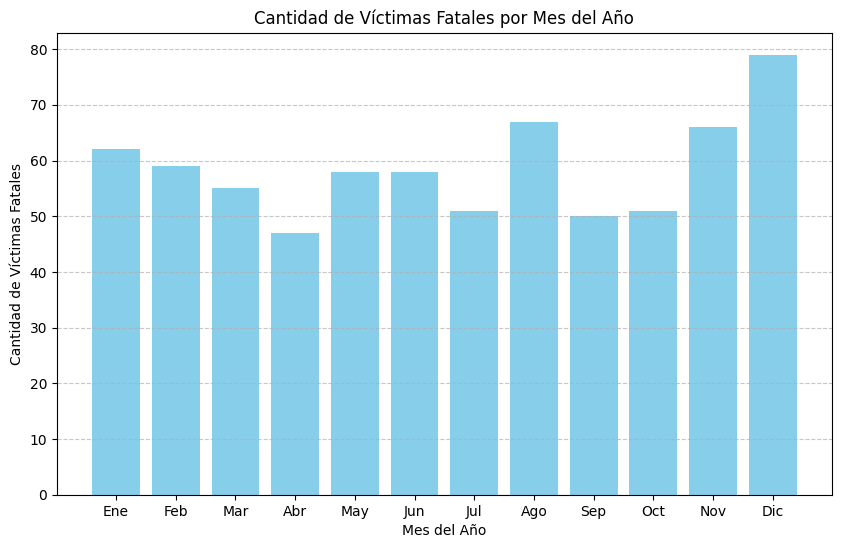

In [297]:
# Contar las víctimas fatales por mes
victimas_por_mes = homicidios['M'].value_counts().sort_index()

# Nombres de los meses para etiquetas en el eje x
nombres_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(victimas_por_mes.index, victimas_por_mes.values, color='skyblue')
plt.xlabel('Mes del Año')
plt.ylabel('Cantidad de Víctimas Fatales')
plt.title('Cantidad de Víctimas Fatales por Mes del Año')
plt.xticks(victimas_por_mes.index, nombres_meses)  # Etiquetas del eje x con nombres de los meses
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Cantidad de muertes según día de la semana (gráfico de barra)

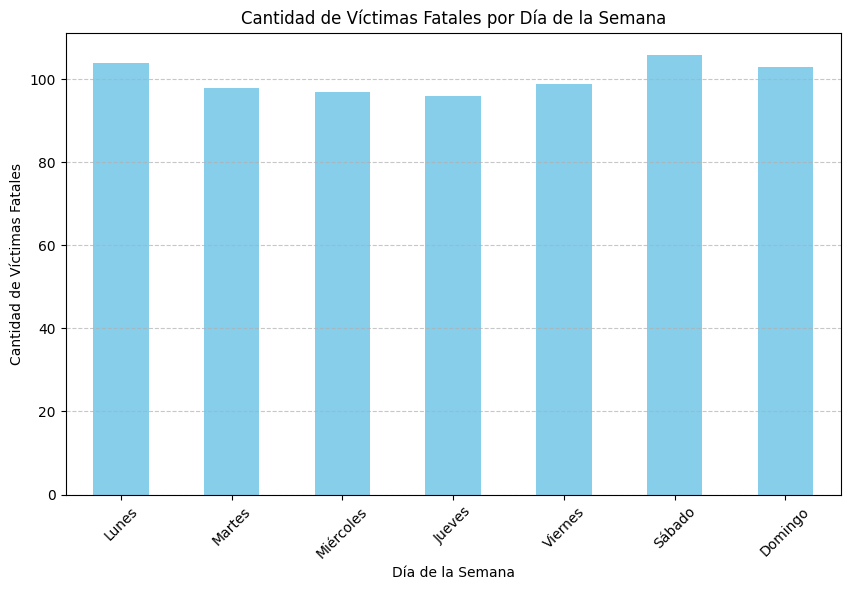

In [298]:
# Contar las víctimas fatales por día de la semana
victimas_por_dia_semana = homicidios['DIA_SEMANA'].value_counts().reindex(['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
victimas_por_dia_semana.plot(kind='bar', color='skyblue')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad de Víctimas Fatales')
plt.title('Cantidad de Víctimas Fatales por Día de la Semana')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Cantidad de muertes por año

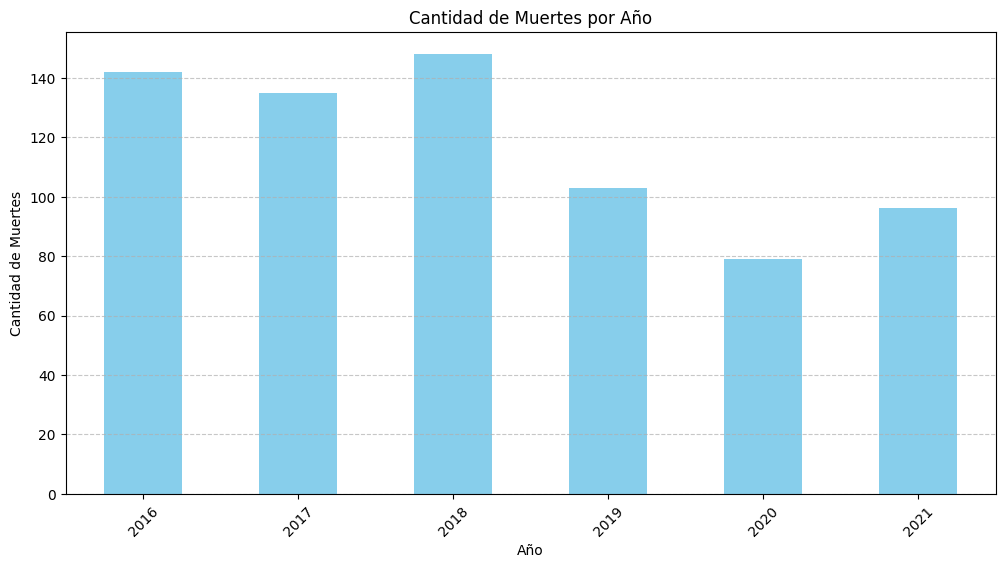

In [299]:
# Crear un gráfico de barras de cantidad de muertes por año
plt.figure(figsize=(12, 6))
homicidios['A'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Año')
plt.ylabel('Cantidad de Muertes')
plt.title('Cantidad de Muertes por Año')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Cantidad de muertes por tipo de calle

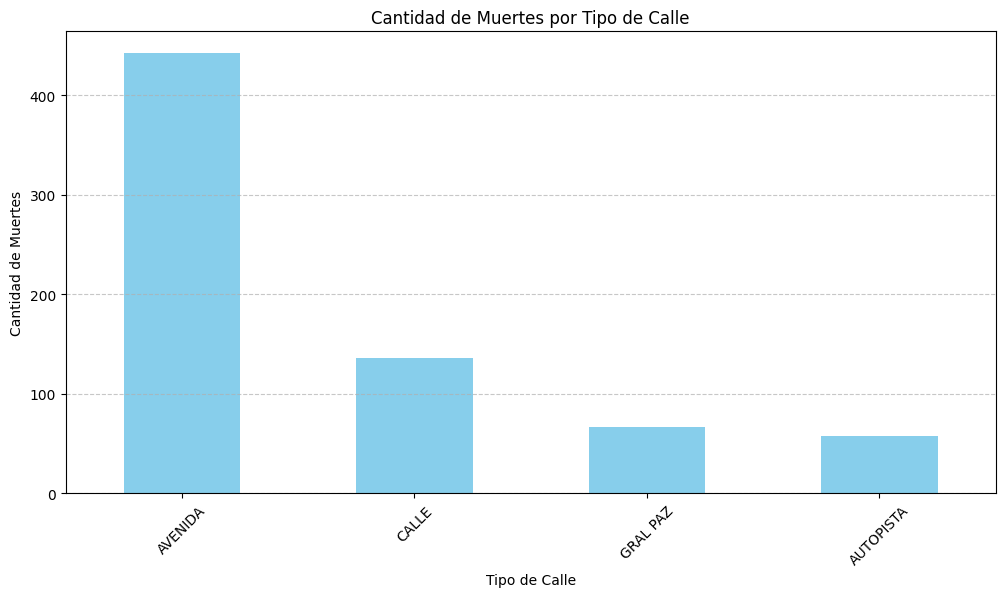

In [300]:
# Crear un gráfico de barras de cantidad de muertes por 'TIPO_CALLE'
plt.figure(figsize=(12, 6))
homicidios['TIPO_CALLE'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Tipo de Calle')
plt.ylabel('Cantidad de Muertes')
plt.title('Cantidad de Muertes por Tipo de Calle')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Cantidad de muertes por tipo de acusado

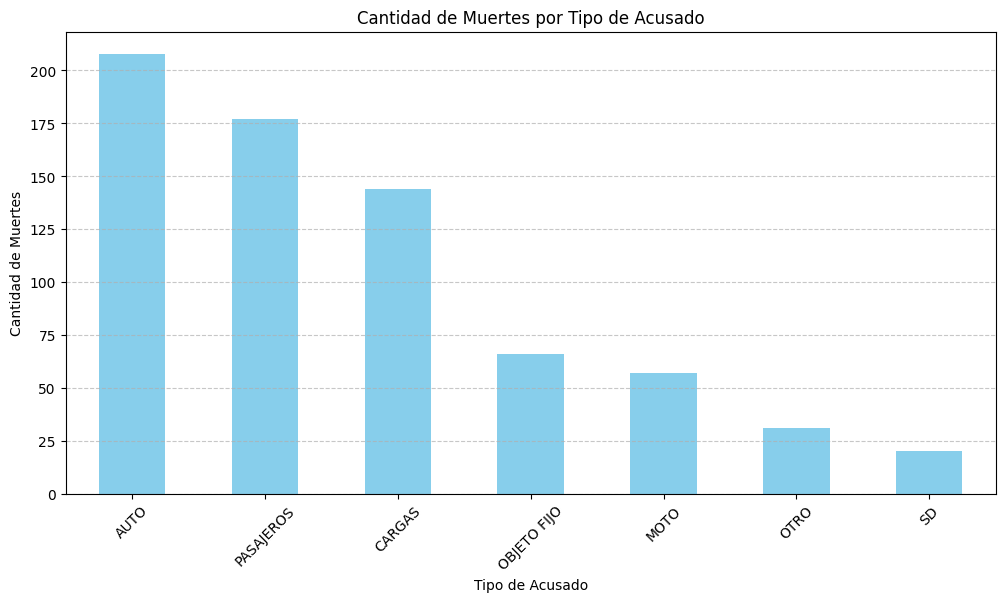

In [301]:
# Crear un gráfico de barras de cantidad de muertes por 'ACUSADO'
plt.figure(figsize=(12, 6))
homicidios['ACUSADO'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Tipo de Acusado')
plt.ylabel('Cantidad de Muertes')
plt.title('Cantidad de Muertes por Tipo de Acusado')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Cantidad de Lesiones por acusado

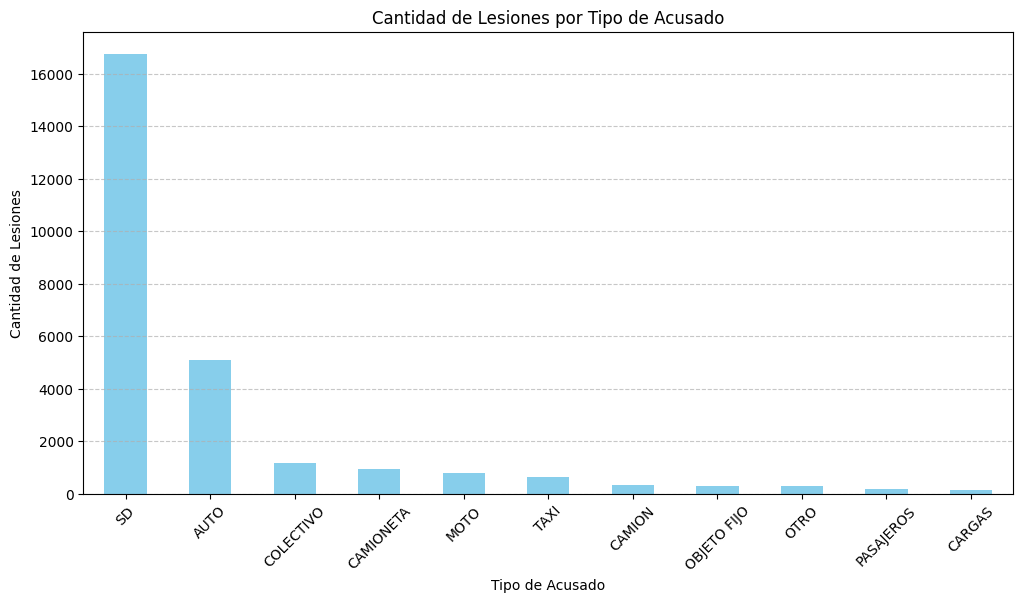

In [302]:
# Crear un gráfico de barras de cantidad de Lesiones por 'ACUSADO'
plt.figure(figsize=(12, 6))
siniestros['ACUSADO'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Tipo de Acusado')
plt.ylabel('Cantidad de Lesiones')
plt.title('Cantidad de Lesiones por Tipo de Acusado')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Cantidad de muertes por tipo de víctima

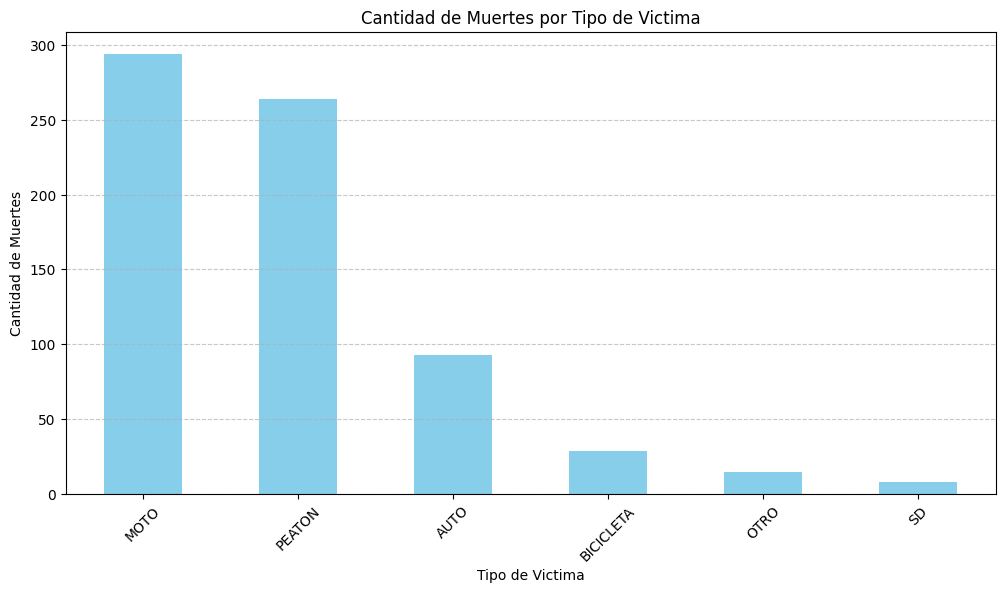

In [303]:
# Crear un gráfico de barras de cantidad de muertes por 'VICTIMA'
plt.figure(figsize=(12, 6))
homicidios['VICTIMA'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Tipo de Victima')
plt.ylabel('Cantidad de Muertes')
plt.title('Cantidad de Muertes por Tipo de Victima')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Cantidad de Lesiones por víctima

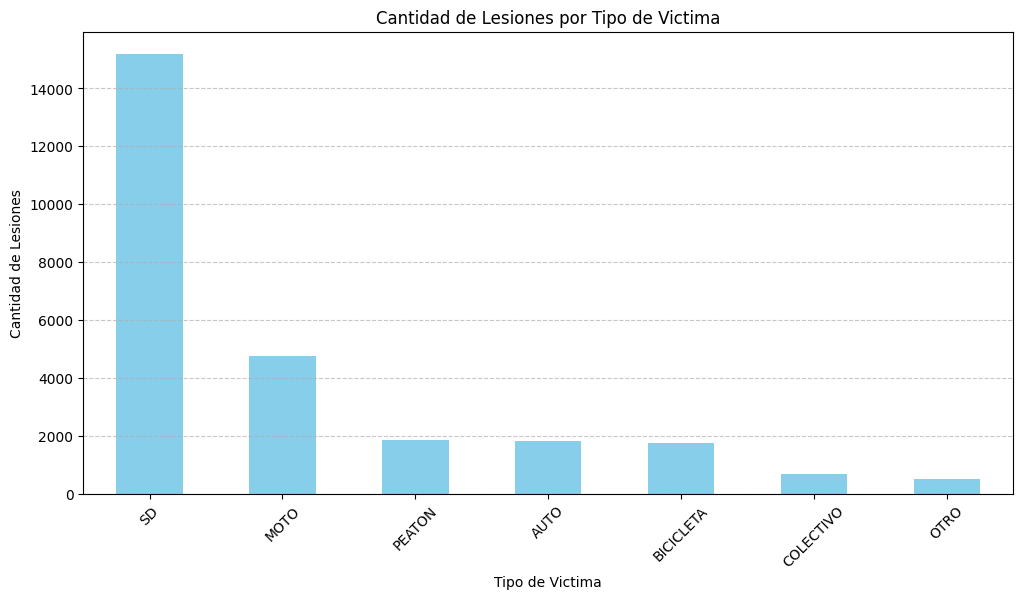

In [304]:
# Crear un gráfico de barras de cantidad de Lesiones por 'VICTIMA'
plt.figure(figsize=(12, 6))
siniestros['VICTIMA'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Tipo de Victima')
plt.ylabel('Cantidad de Lesiones')
plt.title('Cantidad de Lesiones por Tipo de Victima')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

# Cantidad de muertes por comuna

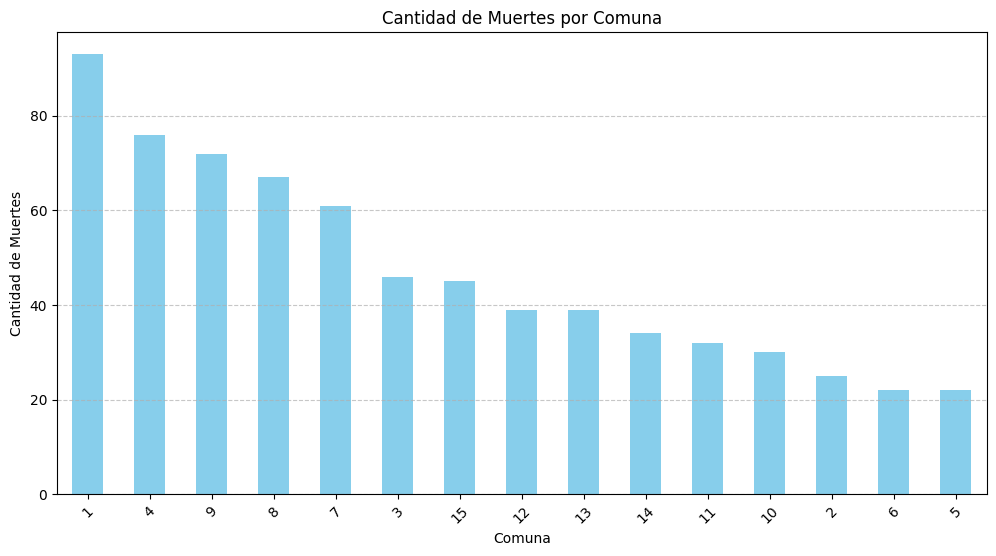

In [305]:
# Crear un gráfico de barras de cantidad de muertes por 'COMUNA'
plt.figure(figsize=(12, 6))
homicidios['COMUNA'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Comuna')
plt.ylabel('Cantidad de Muertes')
plt.title('Cantidad de Muertes por Comuna')
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para que sean legibles
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

***
***

# Cantidad de muertes por mes (gráfico de lineas)

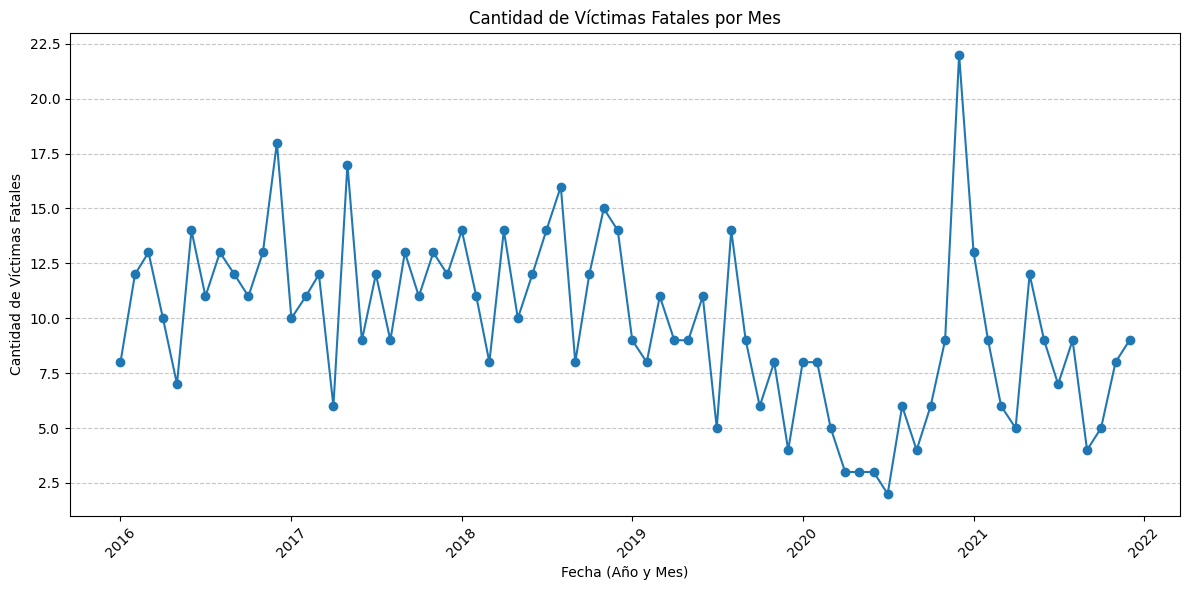

In [306]:
# Agrupar por mes y contar las víctimas fatales
victimas_por_mes = homicidios.groupby(['A', 'M'])['FATAL'].sum().reset_index()

# Crear un índice de fecha combinando el año y el mes
victimas_por_mes['FECHA'] = pd.to_datetime(victimas_por_mes['A'].astype(str) + '-' + victimas_por_mes['M'].astype(str) + '-01')

# Ordenar por fecha
victimas_por_mes = victimas_por_mes.sort_values(by='FECHA')

# Crear el gráfico de líneas
plt.figure(figsize=(12, 6))
plt.plot(victimas_por_mes['FECHA'], victimas_por_mes['FATAL'], marker='o', linestyle='-')
plt.xlabel('Fecha (Año y Mes)')
plt.ylabel('Cantidad de Víctimas Fatales')
plt.title('Cantidad de Víctimas Fatales por Mes')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Cantidad de muertes por mes (gráfico de barras)

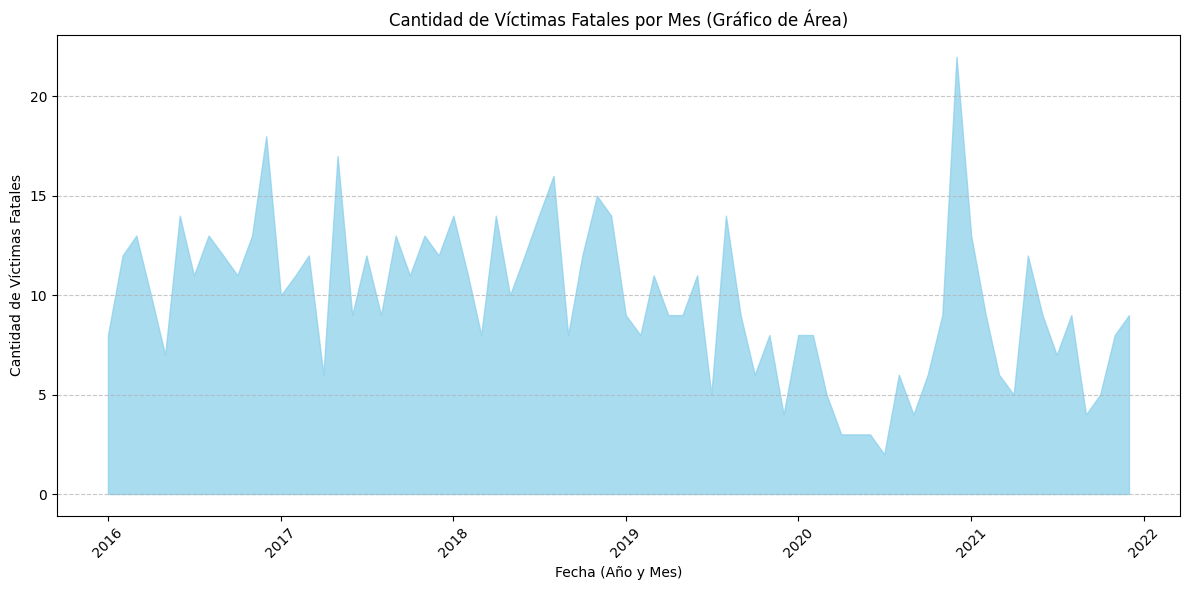

In [307]:
plt.figure(figsize=(12, 6))
plt.fill_between(victimas_por_mes['FECHA'], victimas_por_mes['FATAL'], color='skyblue', alpha=0.7)
plt.xlabel('Fecha (Año y Mes)')
plt.ylabel('Cantidad de Víctimas Fatales')
plt.title('Cantidad de Víctimas Fatales por Mes (Gráfico de Área)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

***
***

# Muertes según hora, según día de la semana

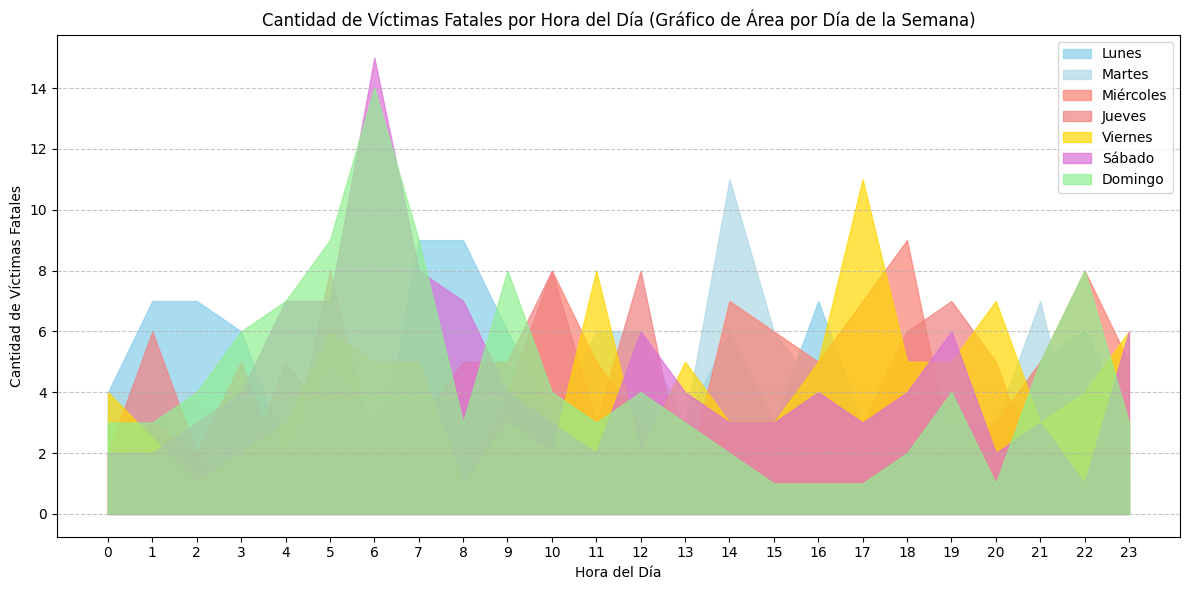

In [308]:
# Crear un diccionario de colores por día de la semana
colores_por_dia = {
    'Lunes': 'skyblue',
    'Martes': 'lightblue',
    'Miércoles': 'salmon',
    'Jueves': 'lightcoral',
    'Viernes': 'gold',
    'Sábado': 'orchid',
    'Domingo': 'lightgreen'
}

# Crear el gráfico de áreas subdividido por día de la semana
plt.figure(figsize=(12, 6))
for dia, color in colores_por_dia.items():
    filtro = homicidios['DIA_SEMANA'] == dia
    victimas_por_hora = homicidios[filtro].groupby('H')['FATAL'].sum()
    plt.fill_between(victimas_por_hora.index, victimas_por_hora.values, color=color, alpha=0.7, label=dia)

plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Víctimas Fatales')
plt.title('Cantidad de Víctimas Fatales por Hora del Día (Gráfico de Área por Día de la Semana)')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')  # Agregar leyenda
plt.tight_layout()
plt.show()

# Cantidad de accidentes con lesiones según  horario

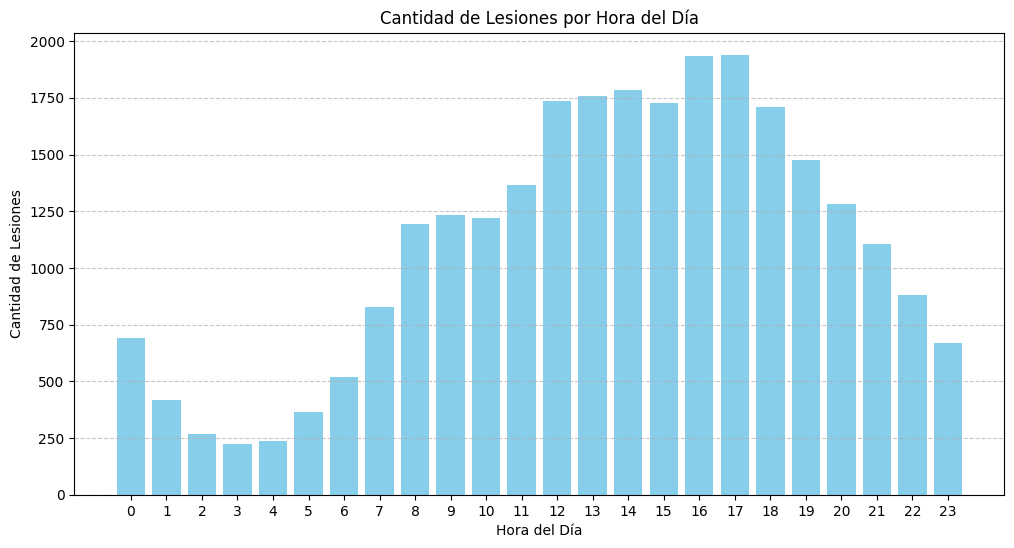

In [309]:
# Contar las víctimas fatales por hora
victimas_por_hora = siniestros['H'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(victimas_por_hora.index, victimas_por_hora.values, color='skyblue')
plt.xlabel('Hora del Día')
plt.ylabel('Cantidad de Lesiones')
plt.title('Cantidad de Lesiones por Hora del Día')
plt.xticks(range(24))  # Etiquetas del eje x para cada hora
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mapa de accidentes fatales

In [310]:
# Lista de latitudes y longitudes de ejemplo
latitudes = homicidios.LATITUD.tolist()
longitudes = homicidios.LONGITUD.tolist()

# Crear un mapa centrado en la ubicación promedio de latitud y longitud
mapa = folium.Map(location=[sum(latitudes)/len(latitudes), sum(longitudes)/len(longitudes)], zoom_start=12)

# Agregar un marcador en el mapa para cada par de latitud y longitud
for lat, lon in zip(latitudes, longitudes):
    folium.Marker([lat, lon]).add_to(mapa)

# Mostrar el mapa
mapa